# Train Models

This notebook trains the followiing models on multiple trials to test the performance of the models on the dataset.

In [12]:
import pandas as pd
import numpy as np
import re
import os
from matplotlib.colors import hex2color
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from tqdm import tqdm
import json

## Reusable functions

In [13]:
def load_dataset(filepath):
    df = pd.read_csv(filepath)

    # Rename columns
    df.rename(columns={"type": "target"}, inplace=True)

    # Rename labels to support binary classification
    df["target"] = df["target"].map(
        lambda x: "malicious" if x != "benign" else "benign"
    )

    return df

In [14]:
def tokenize_urls(urls):
    tokenized_urls = []

    for url in urls:
        # Remove sequential strings following '#' and '?'
        url = re.sub(r"#.*", "", url)
        url = re.sub(r"\?.*", "", url)

        # Split the URL into protocol and rest (domain, path and file)
        protocol, rest = url.split("://", 1) if "://" in url else ("", url)

        # Split the rest into domain and rest (path and file)
        domain, rest = rest.split("/", 1) if "/" in rest else (rest, "")

        # Split the rest into path and file
        path, file = rest.rsplit("/", 1) if "/" in rest else (rest, "")

        tokenized_urls.append([protocol, domain, path, file])

    return tokenized_urls

In [15]:
def train_word2vec_model(
    sentences,
    model_path="./models/word2vec.model",
    load_model=False,
    save_model=True,
):
    if load_model:
        return Word2Vec.load(model_path)

    model = Word2Vec(
        sentences,
        vector_size=200,
        window=5,
        min_count=2,
        workers=10,
        sg=1,
        epochs=15,
        negative=10,
    )

    if save_model:
        model.save(model_path)

    return model

In [16]:
def get_url_embeddings(url_setences, model):
    url_embeddings = []

    for tokenized_url in url_setences:
        # Get embeddings for each token in the URL
        embeddings = [model.wv[token] for token in tokenized_url if token in model.wv]

        # If tokens are present in the model vocabulary, compute the mean of the embeddings
        # Else, return a zero vector
        url_embeddings.append(
            np.mean(embeddings, axis=0) if embeddings else np.zeros(model.vector_size)
        )

    return url_embeddings

In [17]:
def train_evaluate_model(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    batch_size=10000,
):
    accuracy_list = []

    # Calculate the total number of batches
    total_batches = len(X_train) // batch_size + (1 if len(X_train) % batch_size != 0 else 0)

    print(f"Training {type(model).__name__} on {total_batches} batches")

    for i in tqdm(range(0, len(X_train), batch_size), total=total_batches, desc="Batches"):

        # Define the batches
        X_train_batch = X_train[i : i + batch_size]
        y_train_batch = y_train[i : i + batch_size]

        # Train model on batch
        if hasattr(model, 'partial_fit'):
            model.partial_fit(X_train_batch, y_train_batch, classes=["benign", "malicious"])
        else:
            if type(model).__name__ == "RandomForestClassifier":
                model.n_estimators += 10
            model.fit(X_train_batch, y_train_batch)

        # Predict on test set
        y_pred = model.predict(X_test)

        # Add accuracy to accuracy list
        accuracy_list.append(accuracy_score(y_test, y_pred))

    return model, accuracy_list

In [18]:
def run_trial(X_train, y_train, X_test, y_test):
    accuracy_dict = {}

    # Train and evaluate models
    for model in [
        RandomForestClassifier(n_estimators=10, n_jobs=15, warm_start=True),
        GaussianNB(),
    ]:
        # Train and evaluate model
        trained_model, accuracy_list = train_evaluate_model(
            model, X_train, y_train, X_test, y_test
        )

        # Add accuracy list to accuracy dictionary
        accuracy_dict[type(model).__name__] = { "accuracy_list": accuracy_list }
        
        # Predict on the trained model
        y_pred = trained_model.predict(X_test)

        # Print classification report
        accuracy_dict[type(model).__name__]["report"] = classification_report(y_test, y_pred, digits=4, zero_division=0)

    return accuracy_dict

## Run multiple trials

In [19]:
# Load datasets
DATASET_FILES = [
    "./datasets/malicious_phish.csv"
]

trials = [(filepath, load_dataset(filepath)) for filepath in DATASET_FILES]

In [20]:
trial_performances = {}

for name, trial_df in trials:
    trial_performances[name] = {}
    
    # Tokenize URLs
    url_sentences = tokenize_urls(trial_df["url"].tolist())

    # Train Word2Vec model
    word2vec_model = train_word2vec_model(url_sentences, load_model=True)

    # Get URL embeddings
    url_embeddings = get_url_embeddings(url_sentences, word2vec_model)

    # Split dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        url_embeddings, trial_df["target"].tolist(), test_size=0.2, random_state=42
    )
    
    trial_performances[name] = run_trial(X_train, y_train, X_test, y_test)
    

Training RandomForestClassifier on 53 batches


Batches: 100%|██████████| 53/53 [01:43<00:00,  1.95s/it]


Training GaussianNB on 53 batches


Batches: 100%|██████████| 53/53 [02:27<00:00,  2.78s/it]


In [21]:
# Save the trial performances
output_dir = "./outputs"
os.makedirs(output_dir, exist_ok=True)
json.dump(trial_performances, open(f"{output_dir}/trial_performances.json", "w"), indent=4)

In [22]:
# Create the "plots" directory if it doesn't exist
output_dir = "./plots"
os.makedirs(output_dir, exist_ok=True)

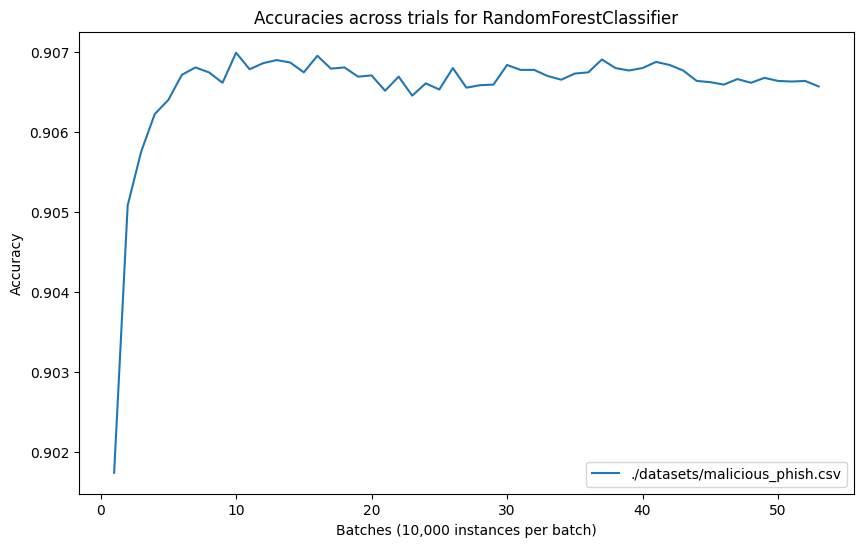

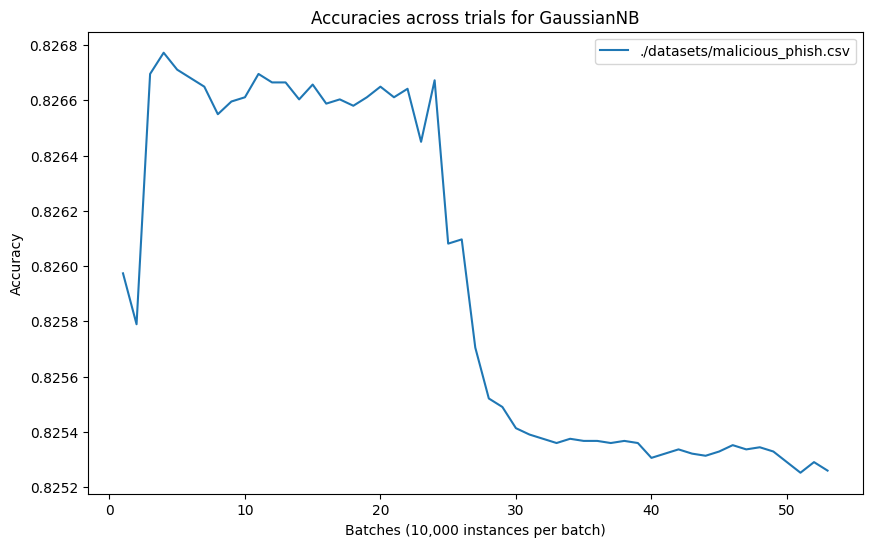

Classification Report for RandomForestClassifier in ./datasets/malicious_phish.csv:

              precision    recall  f1-score   support

      benign     0.8814    0.9916    0.9332     85778
   malicious     0.9787    0.7425    0.8444     44461

    accuracy                         0.9066    130239
   macro avg     0.9300    0.8671    0.8888    130239
weighted avg     0.9146    0.9066    0.9029    130239

Classification Report for GaussianNB in ./datasets/malicious_phish.csv:

              precision    recall  f1-score   support

      benign     0.8456    0.8989    0.8714     85778
   malicious     0.7779    0.6833    0.7275     44461

    accuracy                         0.8253    130239
   macro avg     0.8117    0.7911    0.7994    130239
weighted avg     0.8224    0.8253    0.8223    130239



In [23]:
for model_name in ["RandomForestClassifier", "GaussianNB"]:
    # Plot line graph per model with each trial plotted together
    plt.figure(figsize=(10, 6))
    for trial_name, trials_data in trial_performances.items():
        for name, model_data in trials_data.items():
            if name == model_name:
                accuracies = model_data["accuracy_list"]
                plt.plot(range(1, len(accuracies) + 1), accuracies, label=trial_name)
    plt.xlabel("Batches (10,000 instances per batch)")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracies across trials for {model_name}")
    plt.legend()
    plt.show()

    # Save the figure to the "plots" directory
    output_path = os.path.join(output_dir, f"{model_name}_accuracies_plot.png")
    plt.savefig(output_path)
    plt.close()


    # Plot bar graph with the trials grouped together and the model as the x-axis
    plt.figure(figsize=(10, 6))
    trial_names = list(trial_performances.keys())
    accuracies = [trial_performances[trial_name][model_name]["accuracy_list"] for trial_name in trial_names]
    bar_width = 0.35
    index = np.arange(len(trial_names))

    for i, trial_name in enumerate(trial_names):
        plt.bar(index + i * bar_width, accuracies[i], width=bar_width, label=trial_name)

    plt.xlabel("Trial")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy for {model_name} across Trials")
    plt.xticks(index + bar_width * (len(trial_names) - 1) / 2, trial_names)
    plt.legend()
    
    # Save the figure to the "plots" directory
    output_path = os.path.join(output_dir, f"{model_name}_trial_accuracies_plot.png")
    plt.savefig(output_path)
    plt.close()

    
# Print classification report for each model
for trial_name, trial_data in trial_performances.items():
    for model_name, model_data in trial_data.items():
        report = model_data["report"]
        print(f"Classification Report for {model_name} in {trial_name}:\n")
        print(report)